In [1]:
import sys
sys.path.insert(0, "../src/efficientdet-pytorch")
# sys.path.insert(0, "../src/eff_v1")
sys.path.insert(0, "../src/omegaconfig")
sys.path.insert(0, "../src/wbf")

from ensemble_boxes import *
import torch
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from matplotlib import pyplot as plt
from effdet import get_efficientdet_config, EfficientDet, DetBenchPredict# DetBenchEval
from effdet.efficientdet import HeadNet

In [2]:
def get_valid_transforms():
    return A.Compose([
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [3]:
DATA_ROOT_PATH = '../data/test/images'

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [4]:
dataset = DatasetRetriever(
    image_ids=np.array([path.split('/')[-1] for path in glob(f'{DATA_ROOT_PATH}/*.png')]),
    transforms=get_valid_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

batch_size=2

data_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [5]:
def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 16
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchPredict(net, config)
    net.eval()
    return net.cuda()

net = load_net('../src/effdet5/best-checkpoint-037epoch.bin')

In [6]:
def make_predictions(images, score_threshold=0.22):
    images = torch.stack(images).cuda().float()
    predictions = []
    with torch.no_grad():
        img_size = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to("cuda:0")
        det = net(images, torch.tensor([1]*images.shape[0]).float().cuda(), img_size=img_size)
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]
            category = det[i].detach().cpu().numpy()[:,5]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
                'category': category[indexes]
            })
    return [predictions]

def run_wbf(predictions, image_index, image_size=512, iou_thr=0.44, skip_box_thr=0.2, weights=None): # 43
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
#     labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
    category = [prediction[image_index]['category'].tolist()  for prediction in predictions]
#     print(category)
    
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, category, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

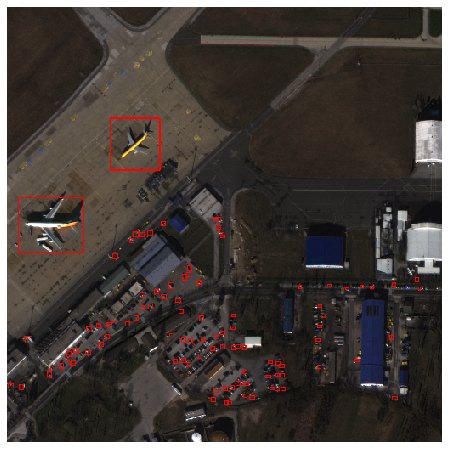

In [7]:
import matplotlib.pyplot as plt

for j, (images, image_ids) in enumerate(data_loader):

    predictions = make_predictions(images)
    
    
    i = 1
    sample = images[i].permute(1,2,0).cpu().numpy()

    boxes, scores, labels = run_wbf(predictions, image_index=i)
    boxes = boxes.astype(np.int32).clip(min=0, max=511)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 1)

    ax.set_axis_off()
    ax.imshow(sample);
    
    break

In [8]:
results = []

for images, image_ids in data_loader:
    predictions = make_predictions(images)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = (boxes*2).clip(min=0, max=1023) #.astype(np.int16)
        image_id = image_ids[i]

        
        labels = labels.astype(int)
        
        result = {
            'file_name': image_id,
            'class_id': labels[:],
            'confidence': scores[:],
#             'bbox': boxes,
            'point1_x': boxes[:, 0],
            'point1_y': boxes[:, 1],
            
            'point2_x': boxes[:, 2],
            'point2_y': boxes[:, 1],
            
            'point3_x': boxes[:, 2],
            'point3_y': boxes[:, 3],
            
            'point4_x': boxes[:, 0],
            'point4_y': boxes[:, 3],
            
#             'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)

In [9]:
sub_df = pd.DataFrame(results[0])

for i in range(1, len(results)):
    sub_df = sub_df.append(pd.DataFrame(results[i]))

In [10]:
sub_df.file_name.nunique()

100

In [11]:
sub_df = sub_df.reset_index().drop(columns=['index'])

In [12]:
sub_df.to_csv('../result/effdet_sub.csv', index=False)

In [13]:
sub_df.class_id.value_counts()

5     5767
1     1016
7      630
11     135
6      101
2       63
8       57
4       52
3       46
9       19
13      16
10      11
12      10
15       9
Name: class_id, dtype: int64